<a href="https://colab.research.google.com/github/neo4j-contrib/training/blob/master/ml_ai/01_DataImport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Short Term Rentals - Data Import

We're going to work with a short term rentals dataset that we got from [InsideAirbnb](http://insideairbnb.com/). We'll be using Neo4j via the popular py2neo library.

First let's install some packages that we'll use in this notebook.

In [ ]:
!pip install py2neo pandas matplotlib

We'll start by importing py2neo and the pandas library which we'll be using to play around with the data later on.

In [ ]:
from py2neo import Graph
import pandas as pd

Create a [Neo4j 3.4 Sandbox](https://neo4j.com/sandbox-v2/) and paste the credentials into the cell below.

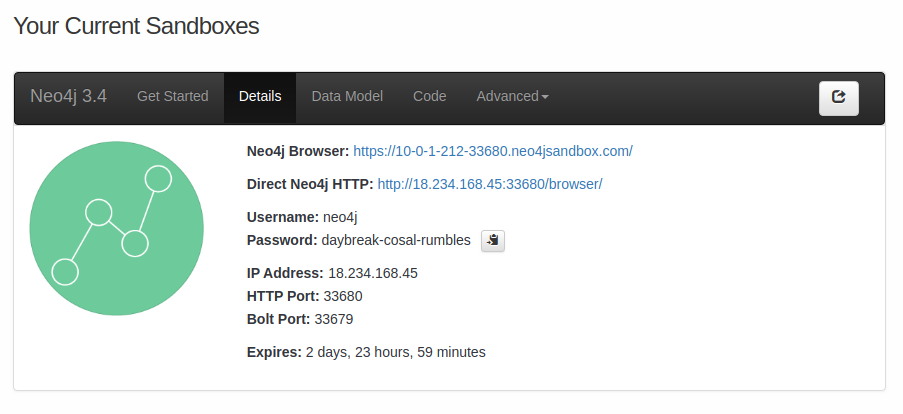


In [ ]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your own Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 

graph = Graph("bolt://18:234.168.45:33679", auth=("neo4j", "daybreak-cosal-rumbles")) 

Now it's time to load the data into Neo4j. This is the graph model that we want to end up with:

<div align="left">
    <img src="images/graph_model.png" alt="Graph Model" width="500px"/>
</div>


Let's create some variables for our import CSV files to simplify our import script:

In [ ]:
listings_file = "https://guides.neo4j.com/listings/data/nyc/listings.csv.gz"
reviews_file = "https://guides.neo4j.com/listings/data/nyc/reviews.csv.gz"

# listings_file = "file:///listings.csv.gz"
# reviews_file = "file:///reviews.csv.gz"

We're going to use Cypher's LOAD CSV command to process these CSV files and create the graph structure described above. Let's start by having a look what we have in both of these files, starting with the listings file:

In [ ]:
explore_listings_csv_query = """
LOAD CSV WITH HEADERS FROM $listingsFile AS row
RETURN row
LIMIT 1
"""
graph.run(explore_listings_csv_query, {"listingsFile": listings_file}).data()

And now the reviews file:

In [ ]:
explore_reviews_csv_query = """
LOAD CSV WITH HEADERS FROM $reviewsFile AS row
RETURN row
LIMIT 1
"""
graph.run(explore_reviews_csv_query, {"reviewsFile": reviews_file}).data()

Try changing `LIMIT 1` if you want to see a few more reviews or listings. 

Otherwise we're now ready to import the dataset into Neo4j:

## Listings

In [ ]:
constraint_query = """
CREATE CONSTRAINT ON (l:Listing)
ASSERT l.id IS UNIQUE
"""

import_query = """
LOAD CSV WITH HEADERS FROM $listingsFile AS row
WITH row WHERE row.id IS NOT NULL
MERGE (l:Listing {id: row.id})
SET l.name = row.name,
    l.price = toFloat(substring(row.price, 1)),
    l.weeklyPrice = toFloat(substring(row.weekly_price, 1)),
    l.cleaningFee = toFloat(substring(row.cleaning_fee, 1)),
    l.propertyType = row.property_type,
    l.accommodates = toInt(row.accommodates),
    l.bedrooms = toInt(row.bedrooms),
    l.bathrooms = toInt(row.bathrooms),
    l.availability365 = toInt(row.availability_365),
    l.location = point({latitude: toFloat(row.latitude), longitude: toFloat(row.longitude)}),
    l.roomType = row.room_type
"""

display(graph.run(constraint_query).summary().counters)
display(graph.run(import_query, {"listingsFile": listings_file}).summary().counters)

## Neighborhoods

In [ ]:
constraint_query = """
CREATE CONSTRAINT ON (n:Neighborhood) 
ASSERT n.id IS UNIQUE
"""

import_query = """
LOAD CSV WITH HEADERS FROM $listingsFile AS row
WITH row WHERE row.id IS NOT NULL
MATCH (l:Listing {id: row.id})
MERGE (n:Neighborhood {id: coalesce(row.neighbourhood_cleansed, "NA")})
ON CREATE SET n.name = row.neighbourhood
MERGE (l)-[:IN_NEIGHBORHOOD]->(n);
"""

graph.run(constraint_query).summary().counters
graph.run(import_query, {"listingsFile": listings_file}).summary().counters

## Amenities

In [ ]:
constraint_query = """
CREATE CONSTRAINT ON (a:Amenity) 
ASSERT a.name IS UNIQUE;
"""

import_query = """
USING PERIODIC COMMIT 1000
LOAD CSV WITH HEADERS FROM $listingsFile AS row
WITH row WHERE row.id IS NOT NULL
MATCH (l:Listing {id: row.id})
WITH l, split(replace(replace(replace(row.amenities, '{', ''), '}', ''), '\"', ''), ',') AS amenities
UNWIND amenities AS amenity
MERGE (a:Amenity {name: amenity})
MERGE (l)-[:HAS]->(a)
"""

graph.run(constraint_query).summary().counters
graph.run(import_query, {"listingsFile": listings_file}).summary().counters

## Hosts

In [ ]:
constraint_query = """
CREATE CONSTRAINT ON (h:Host) 
ASSERT h.id IS UNIQUE
"""

import_query = """
LOAD CSV WITH HEADERS FROM $listingsFile AS row
WITH row WHERE row.host_id IS NOT NULL
MERGE (h:Host {id: row.host_id})
ON CREATE SET h.name      = row.host_name,
              h.about     = row.host_about,
              h.superhost = CASE WHEN row.host_is_super_host = "t" THEN True ELSE False END,
              h.location  = row.host_location,
              h.image     = row.host_picture_url
WITH row, h
MATCH (l:Listing {id: row.id})
MERGE (h)-[:HOSTS]->(l);
"""

graph.run(constraint_query)
graph.run(import_query, {"listingsFile": listings_file}).summary().counters

## Reviews

In [ ]:
user_constraint_query = """
CREATE CONSTRAINT ON (u:User) 
ASSERT u.id IS UNIQUE
"""

review_constraint_query = """
CREATE CONSTRAINT ON (r:Review) 
ASSERT r.id IS UNIQUE
"""


import_query = """
USING PERIODIC COMMIT 10000
LOAD CSV WITH HEADERS FROM $reviewsFile AS row

// User
MERGE (u:User {id: row.reviewer_id})
SET u.name = row.reviewer_name

// Review
MERGE (r:Review {id: row.id})
SET r.date     = row.date,
    r.comments = row.comments
WITH row, u, r
MATCH (l:Listing {id: row.listing_id})
MERGE (u)-[:WROTE]->(r)
MERGE (r)-[:REVIEWS]->(l);
"""

graph.run(user_constraint_query).summary().counters
graph.run(review_constraint_query).summary().counters
graph.run(import_query, {"reviewsFile": reviews_file}).summary().counters

In the next notebook we'll explore the data we've imported.